## Imports

In [106]:
import os
# import logging
import json
import operator
import pandas as pd
import functools
from typing import Annotated, Sequence, List, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
import base64
from pydantic import BaseModel

## Setup

In [107]:

# Load environment variables from .env file
load_dotenv()

# Get API keys and verify they exist
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

excel_filename = 'MurciaFacturas_v1'
image_directory = 'C:/Users/Sergio/GT/AutoAudit/finetune/backend/MurciaFacturas/PagoImages/'
image_filenames = 'B86343514_43F'

## Additional classes

In [108]:
# Use Pydantic BaseModel class
class DocType(BaseModel):
    TIPO: Literal['Orden de transferencia', 'Transferencia emitida', 'Adeudo por transferencia', 'Orden de pago', 'Detalle movimiento', 'Certificado bancario', 'Tarjeta de crédito', 'Extracto movimiento']

class Transferencia(BaseModel):
    TIPO: Literal['Orden de transferencia', 'Transferencia emitida', 'Adeudo por transferencia', 'Orden de pago', 'Detalle movimiento', 'Certificado bancario']
    FECHA_VALOR: str
    ORDENANTE: str
    BENEFICIARIO: str
    CONCEPTO: str
    IMPORTE: float

class TarjetaRow(BaseModel):
    TIPO_DOCUMENTO: Literal['Tarjeta de crédito', 'Extracto movimiento']
    FECHA_VALOR: str
    ORDENANTE: str
    BENEFICIARIO: str | None = None
    CONCEPTO: str
    IMPORTE: float
    
    model_config = {
        "json_schema_extra": {
            "type": "object",
            "properties": {
                "TIPO_DOCUMENTO": {"type": "string", "enum": ["Tarjeta de crédito", "Extracto movimiento"]},
                "FECHA_VALOR": {"type": "string"},
                "ORDENANTE": {"type": "string"},
                "BENEFICIARIO": {"type": "string"},
                "CONCEPTO": {"type": "string"},
                "IMPORTE": {"type": "number"}
            },
            "required": ["TIPO_DOCUMENTO", "FECHA_VALOR", "ORDENANTE", "CONCEPTO", "IMPORTE"]
        }
    }

class TarjetasResponse(BaseModel):
    rows: List[TarjetaRow]

    model_config = {
        "json_schema_extra": {
            "type": "object",
            "properties": {
                "rows": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "TIPO_DOCUMENTO": {"type": "string", "enum": ["Tarjeta de crédito", "Extracto movimiento"]},
                            "FECHA_VALOR": {"type": "string"},
                            "ORDENANTE": {"type": "string"},
                            "BENEFICIARIO": {"type": "string"},
                            "CONCEPTO": {"type": "string"},
                            "IMPORTE": {"type": "number"}
                        },
                        "required": ["TIPO_DOCUMENTO", "FECHA_VALOR", "ORDENANTE", "CONCEPTO", "IMPORTE"]
                    }
                }
            },
            "required": ["rows"]
        }
    }

class FacturaRow(BaseModel):
    CIF_CLIENTE: str
    CLIENTE: str
    FICHERO: str
    NUMERO_FACTURA: str
    FECHA_FACTURA: str
    PROVEEDOR: str
    BASE_IMPONIBLE: str
    CIF_PROVEEDOR: str
    IRPF: str
    IVA: str
    TOTAL_FACTURA: str
    
    model_config = {
        "json_schema_extra": {
            "type": "object",
            "properties": {
                "CIF_CLIENTE": {"type": "string"},
                "CLIENTE": {"type": "string"},
                "FICHERO": {"type": "string"},
                "NUMERO_FACTURA": {"type": "string"},
                "FECHA_FACTURA": {"type": "string"},
                "PROVEEDOR": {"type": "string"},
                "BASE_IMPONIBLE": {"type": "string"},
                "CIF_PROVEEDOR": {"type": "string"},
                "IRPF": {"type": "string"},
                "IVA": {"type": "string"},
                "TOTAL_FACTURA": {"type": "string"}
            },
            "required": ["CIF_CLIENTE", "CLIENTE", "FICHERO", "NUMERO_FACTURA", "FECHA_FACTURA", "PROVEEDOR", "BASE_IMPONIBLE", "CIF_PROVEEDOR", "IRPF", "IVA", "TOTAL_FACTURA"]
        }
    }

class Factura(BaseModel):
    rows: List[FacturaRow]

    model_config = {
        "json_schema_extra": {
            "type": "object",
            "properties": {
                "rows": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "CIF_CLIENTE": {"type": "string"},
                            "CLIENTE": {"type": "string"},
                            "FICHERO": {"type": "string"},
                            "NUMERO_FACTURA": {"type": "string"},
                            "FECHA_FACTURA": {"type": "string"},
                            "PROVEEDOR": {"type": "string"},
                            "BASE_IMPONIBLE": {"type": "string"},
                            "CIF_PROVEEDOR": {"type": "string"},
                            "IRPF": {"type": "string"},
                            "IVA": {"type": "string"},
                            "TOTAL_FACTURA": {"type": "string"}
                        },
                        "required": ["CIF_CLIENTE", "CLIENTE", "FICHERO", "NUMERO_FACTURA", "FECHA_FACTURA", "PROVEEDOR", "BASE_IMPONIBLE", "CIF_PROVEEDOR", "IRPF", "IVA", "TOTAL_FACTURA"]
                    }
                }
            },
            "required": ["rows"]
        }
    }

## State

In [109]:
class AgentState(TypedDict):
    """State for the agents."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

## Tools

In [110]:
@tool
def dic2excel_tarjetas(state: AgentState):
    """Convert a json containing TIPO DOCUMENTO either 'Tarjeta de crédito' or 'Extracto movimiento' into an Excel file using pandas dataframe."""
    try:
        # Get the content from the last message and filename
        last_message = state["messages"][-1]
        content = None
        
        # Try different ways to get the JSON content
        if isinstance(last_message.content, str):
            try:
                # First try: direct JSON parsing
                content = json.loads(last_message.content)
                # Extract rows from the "fila X" structure
                rows = []
                for key in content:
                    if key.startswith('fila'):
                        rows.append(content[key])
                content = rows
                print(f"Processed {len(rows)} rows")
            except json.JSONDecodeError:
                if state["sender"] == "retrieval_agent":
                    content = json.loads(last_message.content)
                    rows = []
                    for key in content:
                        if key.startswith('fila'):
                            rows.append(content[key])
                    content = rows
                else:
                    try:
                        content = [{
                            'TIPO DOCUMENTO': last_message.content[0]['content'],
                            'FECHA VALOR': last_message.content[1]['content'],
                            'ORDENANTE': last_message.content[2]['content'],
                            'DESTINATARIO/BENEFICIARIO': last_message.content[3]['content'],
                            'CONCEPTO': last_message.content[4]['content'],
                            'IMPORTE': last_message.content[5]['content']
                        }]
                    except:
                        return "Error: Could not parse content in any supported format"
        else:
            if isinstance(last_message.content, dict):
                rows = []
                for key in last_message.content:
                    if key.startswith('fila'):
                        rows.append(last_message.content[key])
                content = rows
            else:
                content = [last_message.content]
        if not content:
            return "Error: No valid content found"

        # Create DataFrame from new content
        new_df = pd.DataFrame(content)
        
        # Use current working directory
        output_path = os.path.join(os.getcwd(), excel_filename+'.xlsx')
        
        # Check if file exists
        if os.path.exists(output_path):
            # Read existing Excel file
            existing_df = pd.read_excel(output_path)
            # Concatenate existing and new data
            df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            df = new_df
        
        # Ensure consistent column order
        desired_columns = [
            'DOCUMENTO',
            'TIPO DOCUMENTO',
            'FECHA VALOR',
            'ORDENANTE',
            'DESTINATARIO/BENEFICIARIO',
            'CONCEPTO',
            'IMPORTE'
        ]
        
        # Reorder columns if they exist
        df = df.reindex(columns=desired_columns)
        
        # Save with index=False to avoid extra column
        df.to_excel(output_path, index=False)
        return "Done"
    
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def dic2excel_transferencias(state: AgentState):
    """Convert a json containing TIPO DOCUMENTO either 'Orden de transferencia', 'Transferencia emitida', 'Adeudo por transferencia', 'Orden de pago', 'Detalle movimiento'or 'Certificado bancario' into an Excel file using pandas dataframe."""
    try:
        # Get the content from the last message
        last_message = state["messages"][-1]
        content = None
        
        # Try different ways to get the JSON content
        if isinstance(last_message.content, str):
            try:
                # First try: direct JSON parsing
                parsed_content = json.loads(last_message.content)
                # Handle both list and single object formats
                if isinstance(parsed_content, list):
                    content = parsed_content
                else:
                    content = [parsed_content]
            except json.JSONDecodeError:
                if state["sender"] == "retrieval_agent":
                    parsed_content = json.loads(last_message.content)
                    if isinstance(parsed_content, list):
                        content = parsed_content
                    else:
                        content = [parsed_content]
                else:
                    try:
                        content = [{
                            'TIPO DOCUMENTO': last_message.content[0]['content'],
                            'FECHA VALOR': last_message.content[1]['content'],
                            'ORDENANTE': last_message.content[2]['content'],
                            'DESTINATARIO/BENEFICIARIO': last_message.content[3]['content'],
                            'CONCEPTO': last_message.content[4]['content'],
                            'IMPORTE': last_message.content[5]['content']
                        }]
                    except:
                        return "Error: Could not parse content in any supported format"
        else:
            if isinstance(last_message.content, dict):
                content = [last_message.content]
            elif isinstance(last_message.content, list):
                content = last_message.content
            else:
                return "Error: Content format not supported"

        if not content:
            return "Error: No valid content found"

        # Create DataFrame from content
        new_df = pd.DataFrame(content)
        
        # Use current working directory
        output_path = os.path.join(os.getcwd(), excel_filename+'.xlsx')
        
        # Check if file exists
        if os.path.exists(output_path):
            # Read existing Excel file
            existing_df = pd.read_excel(output_path)
            # Concatenate existing and new data
            df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            df = new_df
        
        # Ensure consistent column order
        desired_columns = [
            'DOCUMENTO',
            'TIPO DOCUMENTO',
            'FECHA VALOR',
            'ORDENANTE',
            'DESTINATARIO/BENEFICIARIO',
            'CONCEPTO',
            'IMPORTE'
        ]
        
        # Reorder columns if they exist
        df = df.reindex(columns=desired_columns)
        
        # Save with index=False to avoid extra column
        df.to_excel(output_path, index=False)
        return "Done"
    
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def dic2excel_facturas(state: AgentState):
    """Convert a json into an Excel file using pandas dataframe."""
    try:
        # Get the content from the last message and filename
        last_message = state["messages"][-1]
        content = None
        
        # Try different ways to get the JSON content
        if isinstance(last_message.content, str):
            try:
                # First try: direct JSON parsing
                content = json.loads(last_message.content)
                # Extract rows from the "fila X" structure
                rows = []
                for key in content:
                    if key.startswith('fila'):
                        rows.append(content[key])
                content = rows
                print(f"Processed {len(rows)} rows")
            except json.JSONDecodeError:
                if state["sender"] == "retrieval_agent":
                    content = json.loads(last_message.content)
                    rows = []
                    for key in content:
                        if key.startswith('fila'):
                            rows.append(content[key])
                    content = rows
                else:
                    try:
                        content = [{
                            'CIF_CLIENTE': last_message.content[0]['content'],
                            'CLIENTE': last_message.content[1]['content'],
                            'NUMERO_FACTURA': last_message.content[2]['content'],
                            'FECHA_FACTURA': last_message.content[3]['content'],
                            'PROVEEDOR': last_message.content[4]['content'],
                            'BASE_IMPONIBLE': last_message.content[5]['content'],
                            'CIF_PROVEEDOR': last_message.content[6]['content'],
                            'IRPF': last_message.content[7]['content'],
                            'IVA': last_message.content[8]['content'],
                            'TOTAL_FACTURA': last_message.content[9]['content']
                        }]
                    except:
                        return "Error: Could not parse content in any supported format"
        else:
            if isinstance(last_message.content, dict):
                rows = []
                for key in last_message.content:
                    if key.startswith('fila'):
                        rows.append(last_message.content[key])
                content = rows
            else:
                content = [last_message.content]
        if not content:
            return "Error: No valid content found"

        # Create DataFrame from new content
        new_df = pd.DataFrame(content)
        
        # Use current working directory
        output_path = os.path.join(os.getcwd(), excel_filename+'.xlsx')
        
        # Check if file exists
        if os.path.exists(output_path):
            # Read existing Excel file
            existing_df = pd.read_excel(output_path)
            # Concatenate existing and new data
            df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            df = new_df
        
        # Ensure consistent column order
        desired_columns = [
            'CIF_CLIENTE',
            'CLIENTE',
            'FICHERO',
            'NUMERO_FACTURA',
            'FECHA_FACTURA',
            'PROVEEDOR',
            'BASE_IMPONIBLE',
            'CIF_PROVEEDOR',
            'IRPF',
            'IVA',
            'TOTAL_FACTURA'
        ]
        
        # Reorder columns if they exist
        df = df.reindex(columns=desired_columns)
        
        # Save with index=False to avoid extra column
        df.to_excel(output_path, index=False)
        return "Done"
    
    except Exception as e:
        return f"Error: {str(e)}"


## Agents

In [111]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    base_message = (
        "You are a helpful AI assistant, collaborating with other assistants."
        " If you are unable to fully answer, that's OK, another assistant with different tools"
        " will help where you left off. Execute what you can to make progress."
    )
    
    if tools:
        prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                base_message + 
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ])
        prompt = prompt.partial(system_message=system_message)
        prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
        return prompt | llm.bind_tools(tools)
    else:
        prompt = ChatPromptTemplate.from_messages([
            (
                "system",
                base_message + "\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ])
        prompt = prompt.partial(system_message=system_message)
        return prompt | llm

llm1 = ChatOpenAI(model="ft:gpt-4o-2024-08-06:personal:pagosicex-v1:AjJ3NLgw")
llm2 = ChatGroq(model="llama3.2-11b-vision-preview")
llm3 = ChatOllama(model="llama3.2-vision").with_structured_output(DocType, method='json_schema')
llm4 = ChatOpenAI(model="gpt-4o-mini")
llm5 = ChatOpenAI(model="ft:gpt-4o-2024-08-06:personal:pagosicex-v4-1:AnS20f6p").with_structured_output(DocType)
llm6 = ChatOpenAI(model="ft:gpt-4o-2024-08-06:personal:pagosicex-v4-1:AnS20f6p")
llm7 = ChatOpenAI(model="ft:gpt-4o-2024-08-06:personal:pagosicex-v4-1:AnS20f6p").with_structured_output(Transferencia)
llm8 = ChatOllama(model="llama3.2")
llm9 = ChatOpenAI(model="ft:gpt-4o-2024-08-06:personal:pagosicex-v4-1:AnS20f6p").with_structured_output(TarjetasResponse)
llm10 = ChatOpenAI(model="ft:gpt-4o-2024-08-06:personal:facturas-v1:Arjf4txC").with_structured_output(Factura)

# Agents

# Retrieval agent
documenttype_agent = create_agent(
    llm5,
    tools=[],
    system_message="""You are a helpful assistant that extracts TIPO from images of invoices and provides the type of image based on the information from the document.
    There are several possible names:
    - Orden de transferencia
    - Transferencia emitida
    - Adeudo por transferencia
    - Orden de pago
    - Detalle movimiento
    - Certificado bancario
    - Extracto movimiento
    - Tarjeta de crédito
    
    In case you are not sure, write CONTINUE. Sometimes the message can contain more than one image. In this case, you shall go image by image and write the TIPO for the first image that contains one of the 8 possible names.
    """
)

retrieval_tarjetas_agent = create_agent(
    llm9,
    tools=[],
    system_message="""You are a helpful assistant that extracts data from images of invoices and provides the data in a structured format.
            All available information is in the image. Please extract the information from the image.
            
            For each row in the document, provide:
            - TIPO_DOCUMENTO: Either 'Tarjeta de crédito' or 'Extracto movimiento'
            - FECHA_VALOR: The date (usually labeled as FECHA, DATA, CONTABLE, F. Valor)
            - ORDENANTE: The payer (write "NOT FOUND" if not in image)
            - DESTINATARIO: Leave empty string
            - CONCEPTO: The transaction description
            - IMPORTE: The amount as a number (convert string to float)
            
            Return the data as a dictionary of rows with keys "fila 1", "fila 2", etc.
    
            Expected output:
            {   
                "rows":[
                    {
                        "TIPO DOCUMENTO": "<text>",
                        "FECHA VALOR": "<text>",
                        "ORDENANTE": "<text>",
                        "DESTINATARIO/BENEFICIARIO": "",
                        "CONCEPTO": "<text>",
                        "IMPORTE": "<text>"
                    },
                    {
                        "TIPO DOCUMENTO": "<text>",
                        "FECHA VALOR": "<text>",
                        "ORDENANTE": "<text>",
                        "DESTINATARIO/BENEFICIARIO": "",
                        "CONCEPTO": "<text>",
                        "IMPORTE": "<text>"
                    }
                ]
            ...
            {rest of rows from table}
            }

            Example:
            {
                "rows": [
                    {
                        "TIPO_DOCUMENTO": "Tarjeta de crédito",
                        "FECHA_VALOR": "08/05/2024",
                        "ORDENANTE": "MUEBLES MIGUEL SURE",
                        "DESTINATARIO": "",
                        "CONCEPTO": "FACT.VENTA WENDYS PC VILLAGE",
                        "IMPORTE": 8.35
                    },
                    {
                        "TIPO_DOCUMENTO": "Tarjeta de crédito",
                        "FECHA_VALOR": "09/05/2024",
                        "ORDENANTE": "MUEBLES MIGUEL SURE",
                        "DESTINATARIO": "",
                        "CONCEPTO": "FACT.VENTA UNITED PETROLEUM",
                        "IMPORTE": 33.76
                    }
                ]
            }
            
            Note: Sometimes the ORDENANTE value is very difficult to find or is NOT inside the image. In this case, write NOT FOUND in ORDENANTE.
            Note: FECHA VALOR is the date and it is usually given as one of the following: FECHA, DATA, CONTABLE, F. Valor... although preference is set to something that contains the word 'VALOR'.
            IMPORTANT: You must always write the date in the format DD/MM/YYYY (e.g. 0702 is translated to 07/02, and 12-04-24 is translated to 12/04/2024).
            Note: TIPO DOCUMENTO can be either 'Tarjeta de crédito' or 'Extracto movimiento'
            
            IMPORTANT: Every row must include ALL fields. Never omit any field.
            """
)

retrieval_transferencias_agent = create_agent(
    llm7,
    tools=[],
    system_message="""You are a helpful assistant that extracts data from images of invoices and provides the desired data in a structured format.
            All available information is in the image. Please extract the information from the image.
            
            Expected output:
            
            {"TIPO DOCUMENTO":"<text>","FECHA VALOR":"<text>","ORDENANTE":"<text>","DESTINATARIO/BENEFICIARIO":"<text>","CONCEPTO":"<text>","IMPORTE":"<text>"}
            
            Example output 1:
            {"TIPO DOCUMENTO":"Orden de transferencia","FECHA VALOR":"26-06-24","ORDENANTE":"RIA MENORCA COLLECTIONS, S.L.","DESTINATARIO/BENEFICIARIO":"ASEPRI","CONCEPTO":"FACTURA V24_334","IMPORTE":"2.359,50"}
            
            Example output 2:
            {"TIPO DOCUMENTO":"Transferencia emitida","FECHA VALOR":"15-11-2024","ORDENANTE":"FIDELTOUR SL. C GREMI DE FISTERS, 33 1 7. 00000 - PALMA 07009","DESTINATARIO/BENEFICIARIO":"THE GLOBAL LOUD SPEAKER S.L.","CONCEPTO":"Factura F-1251","IMPORTE":"3.025,00"}
            
            Example output 3:
            {"TIPO DOCUMENTO":"Detalle movimiento","FECHA VALOR":"14/09/2024","ORDENANTE":"PROART DENTAL","DESTINATARIO/BENEFICIARIO":"PALMES ESTADES, S.L.","CONCEPTO":"Factura 92652","IMPORTE":"334,00"}
            """
)

# Supervisor agent
supervisor_agent = create_agent(
    llm4,
    tools=[dic2excel_facturas],
    system_message="""You are the supervisor agent. You are in charge of the flow of the workflow. You have several options:
    
    1) Make a tool_calls call to use:
    1.a) dic2excel_facturas tool to create an Excel file from the json provided by the retrieval agent. The Excel file has the following columns for every row: "CIF_CLIENTE", "CLIENTE", "NUMERO_FACTURA", "FECHA_FACTURA", "PROVEEDOR", "BASE_IMPONIBLE", "CIF_PROVEEDOR", "IRPF", "IVA", "TOTAL_FACTURA"
    2) Just write FINAL ANSWER when you have successfully created the Excel file. Do NOT add any other text.
    3) Write CONTINUE to pass the message to the retrieval agent in case 1 of the fields is not found. Repeat this up to 4 times and write FINAL ANSWER in case it does not work.
    Do NOT modify the JSON format.
"""
)

retrieval_facturas_agent = create_agent(
    llm10,
    tools=[],
    system_message="""You are a helpful assistant that extracts data from images of invoices and provides the data in a structured format.
            All available information is in the image. Please extract the information from the image.
            
            For each row in the document, provide:
            - CIF_CLIENTE: The CIF name of the client (usually labelled after the word CIF. Its format usually contains a letter and 8 numbers)
            - CLIENTE: The name of the client the CIF_CLIENTE is referring to
            - NUMERO_FACTURA: The number of the invoice
            - FECHA_FACTURA: The date of the invoice
            - PROVEEDOR: The name of the provider the CIF_PROVEEDOR is referring to
            - BASE_IMPONIBLE: str
            - CIF_PROVEEDOR: The CIF name of the provider (usually labelled after the word CIF. Its format usually contains a letter and 8 numbers)
            - IRPF: The value of tax money close to the word IRPF (Impuesto sobre la Renta de las Personas Físicas)
            - IVA: The value of money close to the word IVA (Impuesto del Valor Añadido)
            - TOTAL_FACTURA: The value of money that accounts for all payments of the invoice (sometimes it is labelled under the word TOTAL)
            
            Return the data as a dictionary of rows with keys "fila 1", "fila 2", etc.
    
            Expected output:
            {   
                "rows":[
                    {
                        "CIF_CLIENTE": "<text>",
                        "CLIENTE": "<text>",
                        "NUMERO_FACTURA": "<text>",
                        "FECHA_FACTURA": "<text>",
                        "PROVEEDOR": "<text>",
                        "BASE_IMPONIBLE": "<text>",
                        "CIF_PROVEEDOR": "<text>",
                        "IRPF": "<text>",
                        "IVA": "<text>",
                        "TOTAL_FACTURA": "<text>",
                    },
                    {
                        "CIF_CLIENTE": "<text>",
                        "CLIENTE": "<text>",
                        "NUMERO_FACTURA": "<text>",
                        "FECHA_FACTURA": "<text>",
                        "PROVEEDOR": "<text>",
                        "BASE_IMPONIBLE": "<text>",
                        "CIF_PROVEEDOR": "<text>",
                        "IRPF": "<text>",
                        "IVA": "<text>",
                        "TOTAL_FACTURA": "<text>",
                    }
                ]
            ...
            {rest of rows from table}
            }

            Example:
            {
                "rows": [
                    {
                        "CIF_CLIENTE": A07164841,
                        "CLIENTE": MUEBLES MIGUEL SUREDA SA,
                        "NUMERO_FACTURA": MS-01.23,
                        "FECHA_FACTURA": 5 de noviembre de 2023,
                        "PROVEEDOR": JOSE MATHEU GUILA,
                        "BASE_IMPONIBLE": € 1.350,
                        "CIF_PROVEEDOR": 44.017.026V,
                        "IRPF": € 202,5,
                        "IVA": € 283,5,
                        "TOTAL_FACTURA": € 1.431,
                    },
                    {
                        "CIF_CLIENTE": B07775398,
                        "CLIENTE": WODEN GRUP BOTON. S.L.,
                        "NUMERO_FACTURA": A-2024-13,
                        "FECHA_FACTURA": 15/4/24,
                        "PROVEEDOR": JAIME MARTORELL NÚÑEZ,
                        "BASE_IMPONIBLE": 2.555,09 €,
                        "CIF_PROVEEDOR": 43151009L,
                        "IRPF": 383,26 €,
                        "IVA": 536,57 €,
                        "TOTAL_FACTURA": 2.708,40 €,
                    }
                ]
            }
            
            Note: FECHA FACTURA is the date and it is usually given as one of the following: FECHA, DATA, CONTABLE, F. Valor... although preference is set to something that contains the word 'VALOR'.
            IMPORTANT: You must always write the date in the format DD/MM/YYYY (e.g. 0702 is translated to 07/02, and 12-04-24 is translated to 12/04/2024).
            
            IMPORTANT: Every row must include ALL fields. Never omit any field.
            """
)

# Helper to create nodes
def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    elif isinstance(result, DocType):
        result = AIMessage(content=result.TIPO)
    elif isinstance(result, Transferencia):
        print('Transferencia')
        result = AIMessage(content=json.dumps({
            "TIPO DOCUMENTO": result.TIPO,
            "FECHA VALOR": result.FECHA_VALOR,
            "ORDENANTE": result.ORDENANTE,
            "DESTINATARIO/BENEFICIARIO": result.BENEFICIARIO,
            "CONCEPTO": result.CONCEPTO,
            "IMPORTE": result.IMPORTE
        }))
    elif isinstance(result, TarjetasResponse):
        # Convert the list structure to the dictionary structure expected by the Excel tool
        formatted_response = {}
        for i, row in enumerate(result.rows, 1):
            formatted_response[f"fila {i}"] = {
                "TIPO DOCUMENTO": row.TIPO_DOCUMENTO,
                "FECHA VALOR": row.FECHA_VALOR,
                "ORDENANTE": row.ORDENANTE,
                "DESTINATARIO/BENEFICIARIO": row.BENEFICIARIO or "",
                "CONCEPTO": row.CONCEPTO,
                "IMPORTE": str(row.IMPORTE)
            }
        result = AIMessage(content=json.dumps(formatted_response))
    elif isinstance(result, Factura):
        # Convert the list structure to the dictionary structure expected by the Excel tool
        formatted_response = {}
        for i, row in enumerate(result.rows, 1):
            formatted_response[f"fila {i}"] = {
                "CIF_CLIENTE": row.CIF_CLIENTE,
                "CLIENTE": row.CLIENTE,
                "FICHERO": row.FICHERO,
                "NUMERO_FACTURA": row.NUMERO_FACTURA,
                "FECHA_FACTURA": row.FECHA_FACTURA,
                "PROVEEDOR": row.PROVEEDOR,
                "BASE_IMPONIBLE": row.BASE_IMPONIBLE,
                "CIF_PROVEEDOR": row.CIF_PROVEEDOR,
                "IRPF": row.IRPF,
                "IVA": row.IVA,
                "TOTAL_FACTURA": row.TOTAL_FACTURA
            }
        result = AIMessage(content=json.dumps(formatted_response))

    else:
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
    
    # Create new state preserving all existing fields
    new_state = state.copy()  # Copy all existing state
    new_state.update({
        "messages": [result],
        "sender": name,
    })
    
    return new_state

## Router

In [112]:
def router(state: AgentState) -> str:
    """Route to the appropriate next step in the workflow."""
    last_message = state["messages"][-1]
    sender = state["sender"]
    
    # If there are tool calls, route to tools
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    
    # Safety check - if we've been through supervisor multiple times, end
    if sender == "supervisor_agent" and "FINAL ANSWER" in last_message.content:
        return END
        
    return "continue"

## Workflow

In [113]:
# Workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("supervisor_agent", functools.partial(agent_node, agent=supervisor_agent, name="supervisor_agent"))
workflow.add_node("retrieval_facturas_agent", functools.partial(agent_node, agent=retrieval_facturas_agent, name="retrieval_facturas_agent"))
tools = [dic2excel_facturas]
tools_node = ToolNode(tools)
workflow.add_node("tools", tools_node)

# Add edges
workflow.add_edge(START, "retrieval_facturas_agent")
workflow.add_conditional_edges("retrieval_facturas_agent", router, {
    "continue": "supervisor_agent",
    "tools": "tools",
})
workflow.add_conditional_edges("supervisor_agent", router, {
    "continue": "retrieval_facturas_agent",
    "tools": "tools",
    END: END,
})
workflow.add_conditional_edges("tools", lambda x: x["sender"], {
    "supervisor_agent": "supervisor_agent",
})

# Compile the workflow
graph = workflow.compile()

## Graph

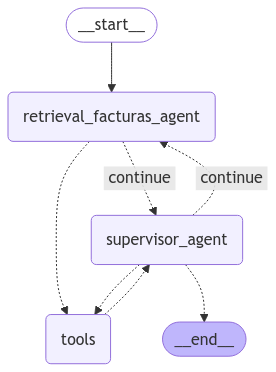

In [114]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Execution

In [115]:
def encode_image(image_path: str) -> str:
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def process_images(image_directory: str, base_filenames: List[str], excel_filename: str):
    """
    Process all images sharing the same base filename in a single batch.
    
    Args:
        image_directory: Directory containing the images
        base_filename: Base filename to match (e.g., 'A30061816_3P HOLA CONSULTING')
        excel_filename: Name of the Excel file to save results
    """
    # Get all files in directory that start with the base_filename
    all_files = os.listdir(image_directory)
    image_paths = [f for f in all_files if f.startswith(base_filenames)]
    
    if not image_paths:
        print(f"No images found matching prefix: {base_filenames}")
        return
    
    # Create message content with all matching images
    message_content = []
    for image_path in image_paths:
        full_path = os.path.join(image_directory, image_path)
        base64_image = encode_image(full_path)
        message_content.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{base64_image}"
            }
        })
    
    # Stream the workflow execution with all images at once
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message_content)
            ],
        },
        config={"recursion_limit": 10}
    )
    
    results = []
    for s in events:
        print(s)
        print("----")
        results.append(s)
    
    # Handle Excel output
    try:
        excel = pd.read_excel(excel_filename+'.xlsx')
    except FileNotFoundError:
        excel = pd.DataFrame()
        
    if results:
        # Get the current row count before any new additions
        start_idx = len(excel) - len(image_paths)
        
        # Update the DOCUMENTO column for the rows just added
        if not excel.empty and start_idx >= 0:
            for i, image_path in enumerate(image_paths):
                excel.loc[start_idx + i, 'FICHERO'] = image_path
                
        # Save after batch processing
        excel.to_excel(excel_filename+'.xlsx', index=False)
            
# Example usage
# image_filenames = [os.listdir(image_directory)[-10]]
# image_filenames = os.listdir(image_directory)
process_images(image_directory, image_filenames, excel_filename)

{'retrieval_facturas_agent': {'messages': [AIMessage(content='{"fila 1": {"CIF_CLIENTE": "ESB10549863", "CLIENTE": "HubSpot", "FICHERO": "40200382L_FACTURAS0002_3", "NUMERO_FACTURA": "11063330", "FECHA_FACTURA": "05/05/2023", "PROVEEDOR": "Ciconea Nutrici\\u00f3n SL", "BASE_IMPONIBLE": "846.72", "CIF_PROVEEDOR": "ESB86343514", "IRPF": "nan", "IVA": "177.8", "TOTAL_FACTURA": "846.72"}}', additional_kwargs={}, response_metadata={})], 'sender': 'retrieval_facturas_agent'}}
----
{'supervisor_agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AmWHeTsL34iVOiRT1ERYc9Fv', 'function': {'arguments': '{"state":{"messages":[{"content":"{\\"fila 1\\": {\\"CIF_CLIENTE\\": \\"ESB10549863\\", \\"CLIENTE\\": \\"HubSpot\\", \\"NUMERO_FACTURA\\": \\"11063330\\", \\"FECHA_FACTURA\\": \\"05/05/2023\\", \\"PROVEEDOR\\": \\"Ciconea Nutrici\\\\u00f3n SL\\", \\"BASE_IMPONIBLE\\": \\"846.72\\", \\"CIF_PROVEEDOR\\": \\"ESB86343514\\", \\"IRPF\\": \\"nan\\", \\"IVA\\": \\"1